## Part 1 implementing QAOA


In [114]:
!pip install myqlm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [115]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges) 
best_b = 0

for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val = 0.     
    for i,j in edges:
        val += (2*b[i]-1)*(2*b[j]-1) #Compute the hamiltonian of the state b with Z-pauli gates
    # END TODO
    if val <= best_value:  #We want to minimize the hamiltonian
        best_value = val
        best_b = b
        
    print('state = ' + str(b)+ ' value = ' + str(val)) #I added this to see every state with their correspondant value

print(best_value)
print(best_b)

state = [0, 0, 0, 0, 0] value = 5.0
state = [0, 0, 0, 0, 1] value = 1.0
state = [0, 0, 0, 1, 0] value = 3.0
state = [0, 0, 0, 1, 1] value = -1.0
state = [0, 0, 1, 0, 0] value = 1.0
state = [0, 0, 1, 0, 1] value = 1.0
state = [0, 0, 1, 1, 0] value = -1.0
state = [0, 0, 1, 1, 1] value = -1.0
state = [0, 1, 0, 0, 0] value = -1.0
state = [0, 1, 0, 0, 1] value = -1.0
state = [0, 1, 0, 1, 0] value = 1.0
state = [0, 1, 0, 1, 1] value = 1.0
state = [0, 1, 1, 0, 0] value = -5.0
state = [0, 1, 1, 0, 1] value = -1.0
state = [0, 1, 1, 1, 0] value = -3.0
state = [0, 1, 1, 1, 1] value = 1.0
state = [1, 0, 0, 0, 0] value = 1.0
state = [1, 0, 0, 0, 1] value = -3.0
state = [1, 0, 0, 1, 0] value = -1.0
state = [1, 0, 0, 1, 1] value = -5.0
state = [1, 0, 1, 0, 0] value = 1.0
state = [1, 0, 1, 0, 1] value = 1.0
state = [1, 0, 1, 1, 0] value = -1.0
state = [1, 0, 1, 1, 1] value = -1.0
state = [1, 1, 0, 0, 0] value = -1.0
state = [1, 1, 0, 0, 1] value = -1.0
state = [1, 1, 0, 1, 0] value = 1.0
state = [1, 1

#### visualization of the graph

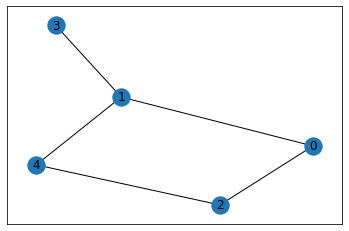

In [116]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [117]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [118]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [119]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    for i in range(n_qubits): 
      layer.apply(RX(theta), i) #We apply one rotation RX(θ) on each qubit
    
    for pair in edges: 
       layer.apply(U_ZZ(beta), pair[0], pair[1]) #“Cost function” layer : Each rotation is decomposed using a sub-circuit of 2 CNOT gates and a single RZ rotation.
    
    return layer

### Question 4

In [120]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    for i in range(0, n_qubits): 
        H(qubits[i]) #layer of Hadamard gates

    for i in range(0,len(parameters),2):
        one_qaoa_layer(n_qubits, edges, parameters[i], parameters[i+1])(qubits) #qaoa layer routine implemented in Question 3
        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)

        b=[int(i) for i in sample.state.bitstring] #Recover the qubit values (nqubits 0 or 1)

        for i,j in edges:
          obs+=(2*b[i]-1)*(2*b[j]-1)*sample.probability #Compute the value of the observable on the state vector
    # END TODO
    return obs
    
        

In [121]:
import numpy as np
np.random.random(3)

array([0.9506814 , 0.20464632, 0.67347878])

In [122]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
# Réponse à la question: To reach the ultimum value for **graph 6**, we can see that a minimimum of **6 layers** is needed.

-2.798556261404529 -3.0677268239453563 -3.5846209098231245 -3.8602614520568026 -4.026592272672698 -4.089507548196499 -4.099542010482528 -4.111935363595633 -4.133584096894213 -4.168405902390412 -4.194865330629363 -4.225058818787059 -4.232301665696414 -4.233321702872744 -4.233809816073815 -4.233931991945127 -4.234125513672794 -4.234310848916469 -4.234341476298028 -4.234345199574411 -4.234345296302358 -4.23434529764901 -0.1556016730622185 -0.7220013177225292 -1.0848186570452236 -1.408002740302953 -2.9574402603560985 -3.7181419866323875 -4.036880880837724 -4.077909074271486 -4.115631155291287 -4.17493846836403 -4.222665236139131 -4.261656469431477 -4.277747973745763 -4.295741266588998 -4.310789333730135 -4.322157241001399 -4.331892720483354 -4.339475309860564 -4.344133013015669 -4.346806757261983 -4.349871894492021 -4.355193067928342 -4.3614102034134055 -4.36893869769043 -4.381251427902869 -4.39844564678085 -4.401539805035577 -4.407119381590592 -4.416949452203173 -4.432557296935365 -4.4411

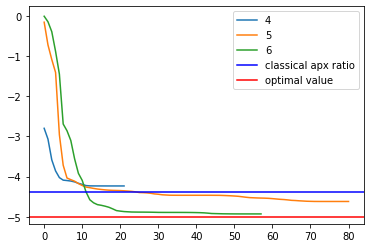

In [126]:
import matplotlib.pylab as plt


for nlayers in range(4,7,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

With the integral approximation and by passing at the exponential, we can obtain the two parameters we want:
Θ=kT/$p^2$ and β=T/p - k/$p^2$

With the graph below, we can see a important acceleration on convergence : With T=0.01 and only 5 layers (against 6 before), the optimum value is reached in 10-15 steps (against 25-30 before)

-1.5259216440733028 -2.2961598145307147 -2.77159606116672 -3.4868292027201595 -3.858364031935637 -3.936096992172265 -3.9781944749185856 -3.9782683940920487 -3.9782690228147346 -3.9782690293576337 -3.9782690296547822 -1.0376625893701463 -2.7811481004036716 -3.7470232186055195 -4.099957547598142 -4.366955490311715 -4.502932590644833 -4.575676764686746 -4.6396022384228415 -4.657163181089284 -4.662138997703945 -4.6625836027151415 -4.662588086596154 -4.66258947154618 -4.662589586163619 -4.662589588174398 -4.662589588288394 -0.6248902414938772 -2.927283307350381 -3.8123424643177617 -4.226911673512273 -4.5326357110082185 -4.636481421649798 -4.700211078667277 -4.76833966375014 -4.783020337702686 -4.806025590138394 -4.838898251899169 -4.862375232640605 -4.87191946784428 -4.880325060815913 -4.881124327563138 -4.881619664484411 -4.8818051150781585 -4.881926931642994 -4.88196145185069 -4.881968457924519 -4.881968639624016 -4.881968643024792 -4.881968643051354 

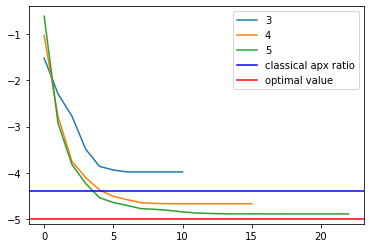

In [124]:
T = 0.01

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init

    beta=[k*T/(nlayers**2)for k in range(1,nlayers+1)] #Compute beta theoretical optimal values
    
    theta=[(T/nlayers)-(k/nlayers**2) for k in range(1,nlayers+1)] #Compute theta theoretical optimal values

    parameters_init = []

    for i in range(nlayers): #We add the parameters values to the parameters_init list
        parameters_init.append(theta[i])
        parameters_init.append(beta[i])

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()